In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!cp -r '/content/drive/Othercomputers/T14S-G14/D:/HCMUT_Workspace/HK251/Digital-Image-Processing-and-Computer-Vision/assignment/landscape2art/monet_style_dataset' /content/

In [22]:
import os
from datetime import datetime
import json
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from conv_autoencoder import ConvAutoencoder
from resnet_autoencoder import ResnetAutoencoder

In [23]:
DATA_DIR = '/content/monet_style_dataset'
MODEL_DIR = '/content/drive/Othercomputers/T14S-G14/D:/HCMUT_Workspace/HK251/Digital-Image-Processing-and-Computer-Vision/assignment/landscape2art/models'

## Prepare Dataset and Dataloader

In [24]:
class PhotoPaintingDataset(Dataset):
    """
    A dataset for paired image-to-image tasks.
    Expects:
        root/photos/xxx.jpg
        root/sketches/xxx.jpg
    with matching filenames in both folders.
    """
    def __init__(self, photos_dir, paintings_dir, indices=None):
        self.photos_dir = photos_dir
        self.paintings_dir = paintings_dir

        # Ensure paired correctly (same length & matching names)
        assert len(os.listdir(photos_dir)) == len(os.listdir(paintings_dir)), \
            "Mismatch in number of files between photos and sketches."

        self.filenames = os.listdir(photos_dir)
        # If indices (train/test) are passed, keep only those
        if indices is not None:
            self.filenames = [self.filenames[i] for i in indices]

        # Match file names in both folders
        self.filenames = sorted(self.filenames)

        self.transformer = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        photo_path = os.path.join(self.photos_dir, self.filenames[idx])
        painting_path = os.path.join(self.paintings_dir, self.filenames[idx])

        photo = Image.open(photo_path).convert("RGB")
        painting = Image.open(painting_path).convert("RGB")  # paintingscale target

        photo = self.transformer(photo)
        painting = self.transformer(painting)

        return photo, painting

In [25]:
photos_dir = os.path.join(DATA_DIR, 'original')
paintings_dir = os.path.join(DATA_DIR, 'stylized')

all_files = sorted(os.listdir(photos_dir))
train_idx, test_idx = train_test_split(range(len(all_files)), test_size=0.2, random_state=42)

train_dataset = PhotoPaintingDataset(photos_dir, paintings_dir, indices=train_idx)
test_dataset = PhotoPaintingDataset(photos_dir, paintings_dir, indices=test_idx)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

## Train and Evaluate function

In [32]:
def train(model, optimizer, criterion, train_loader, val_loader, num_epochs, device):
    model.train()
    num_batches = len(train_loader)
    train_loss_lst = []
    eval_loss_lst = []
    best_loss = float("inf")

    print("🚀 Starting Training...")
    print("=" * 60)

    for epoch in range(num_epochs):
        train_loss = 0
        print(f"Epoch [{epoch+1}/{num_epochs}]: ")
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1:2d}/{num_epochs}",
                   ncols=100, ascii=True, leave=False)

        for batch_idx, (photo, painting) in enumerate(pbar):
            photo, painting = photo.to(device), painting.to(device)
            # Forward pass
            output = model(painting)
            loss = criterion(output, photo)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx % 10 == 0:
                progress = (batch_idx + 1) / num_batches * 100
                bar = "█" * int(progress // 5) + "░" * (20 - int(progress // 5))
                pbar.set_description(f"Epoch {epoch+1:2d}/{num_epochs} [{bar}]")

        train_loss = evaluate(model, criterion, train_loader, device)
        print(f"Training Loss: {train_loss:.4f}")

        eval_loss = evaluate(model, criterion, val_loader, device)
        print(f"Validation Loss: {eval_loss:.4f}")

        if eval_loss < best_loss:
            best_loss = eval_loss
            save_model(
                model,
                model_dir=MODEL_DIR,
                name=None,
                config={
                    "hidden_channels": hidden_channels,
                    "learning_rate": learning_rate,
                },
                optimizer=optimizer,
                epoch=epoch,
                metrics={"train_loss": train_loss, "eval_loss": eval_loss},
            )

        train_loss_lst.append(train_loss)
        eval_loss_lst.append(eval_loss)

    return train_loss_lst, eval_loss_lst

def evaluate(model, criterion, test_loader, device) -> float:
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for photo, painting in test_loader:
            photo, painting = photo.to(device), painting.to(device)
            # Forward pass
            output = model(painting)
            loss = criterion(output, photo)

            eval_loss += loss.item()
    eval_loss = eval_loss / len(test_loader)
    return eval_loss

def save_model(model, model_dir, name=None, config=None, optimizer=None, epoch=None, metrics=None):
    """Save weights (+ optional optimizer) and a tiny JSON log."""
    os.makedirs(model_dir, exist_ok=True)

    base = f"{(name or type(model).__name__)}"
    ckpt_path = os.path.join(model_dir, f"{base}.pt")
    log_path  = os.path.join(model_dir, f"{base}_log.json")

    # keep checkpoint minimal & portable
    checkpoint = {
        "state_dict": model.state_dict(),
        "config": config or {},                 # only JSON-serializable stuff
        "epoch": epoch,
        "optimizer_state": optimizer.state_dict() if optimizer else None,
    }
    torch.save(checkpoint, ckpt_path)

    # human-readable log (pure JSON)
    log = {
        "file": base,
        "model_class": type(model).__name__,
        "epoch": epoch,
        "metrics": metrics or {},
    } | (config or {})
    with open(log_path, "w") as f:
        json.dump(log, f, indent=2)

    return {"checkpoint": ckpt_path, "log": log_path}

def load_model(model_class, ckpt_path, map_location="cpu"):
    """Rebuild model from config and load weights."""
    ckpt = torch.load(ckpt_path, map_location=map_location)
    model = model_class(**ckpt.get("config", {}))
    model.load_state_dict(ckpt["state_dict"])
    model.eval()
    return model, ckpt

## Train and Evaluate ConvAutoencoder

In [30]:
hidden_channels = [64, 128, 256]
learning_rate = 2e-3
NUM_EPOCHS = 15

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConvAutoencoder(in_channel=3, out_channel=3, hidden_channels=hidden_channels).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_lst, eval_loss_lst = train(model, optimizer, criterion,
                                      train_loader, test_loader, num_epochs=NUM_EPOCHS, device=device)

🚀 Starting Training...
Epoch [1/15]: 


Training Loss: 0.0588
Validation Loss: 0.0574
Epoch [2/15]: 


Training Loss: 0.0549
Validation Loss: 0.0542
Epoch [3/15]: 


Training Loss: 0.0535
Validation Loss: 0.0530
Epoch [4/15]: 


Training Loss: 0.0541
Validation Loss: 0.0531
Epoch [5/15]: 


Training Loss: 0.0525
Validation Loss: 0.0514
Epoch [6/15]: 


Training Loss: 0.0511
Validation Loss: 0.0501
Epoch [7/15]: 


Training Loss: 0.0492
Validation Loss: 0.0483
Epoch [8/15]: 


Training Loss: 0.0507
Validation Loss: 0.0500
Epoch [9/15]: 


Training Loss: 0.0484
Validation Loss: 0.0481
Epoch [10/15]: 


Training Loss: 0.0513
Validation Loss: 0.0500
Epoch [11/15]: 


Training Loss: 0.0465
Validation Loss: 0.0457
Epoch [12/15]: 


Training Loss: 0.0476
Validation Loss: 0.0473
Epoch [13/15]: 


Training Loss: 0.0462
Validation Loss: 0.0457
Epoch [14/15]: 


Training Loss: 0.0445
Validation Loss: 0.0447
Epoch [15/15]: 


Training Loss: 0.0458
Validation Loss: 0.0459


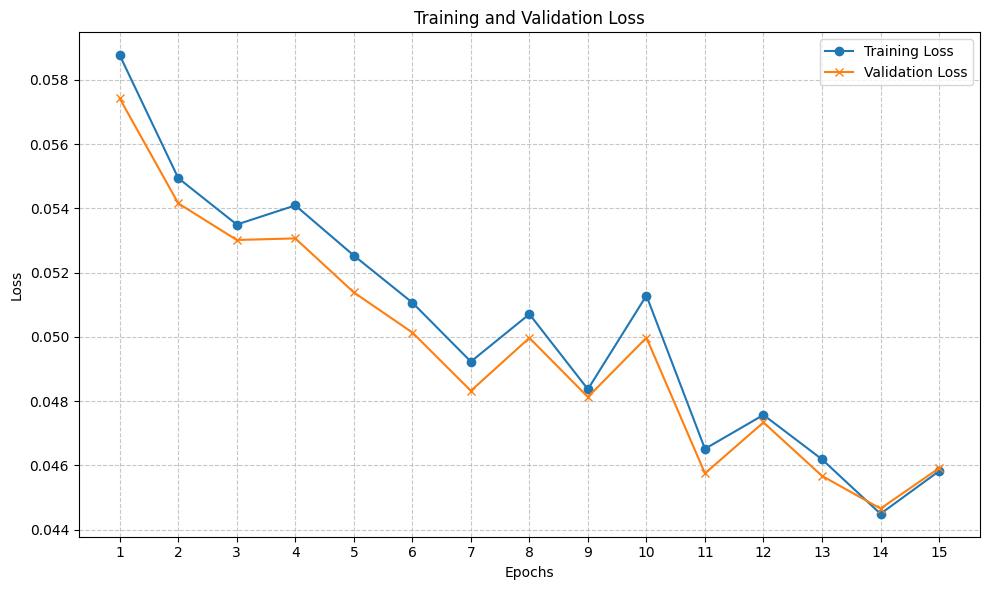

In [34]:
def plot_losses(train_loss_lst, eval_loss_lst):
    # Plot training and evaluation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_loss_lst) + 1), train_loss_lst, label='Training Loss', marker='o')
    plt.plot(range(1, len(eval_loss_lst) + 1), eval_loss_lst, label='Validation Loss', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(1, len(train_loss_lst) + 1))
    plt.tight_layout()
    plt.show()

plot_losses(train_loss_lst, eval_loss_lst)

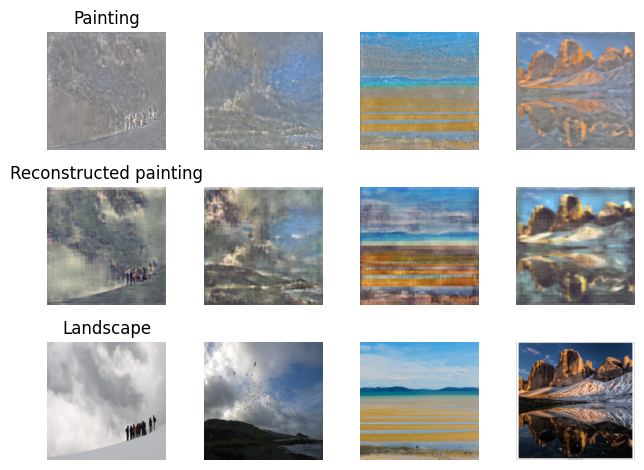

In [35]:
def show_examples(model, data_loader, idx, device):
    model.eval()
    with torch.no_grad():
        it = iter(data_loader)
        photo, painting = next(it)
        for i in range(idx):
          photo, painting = next(it)

        painting, photo = painting.to(device), photo.to(device)
        output = model(painting)

        painting = painting.cpu().numpy()
        photo = photo.cpu().numpy()
        output = output.cpu().numpy()

        fig, axes = plt.subplots(3, 4)
        for i in range(4):
            # Display paintingscale input
            axes[0, i].imshow(painting[i].transpose(1, 2, 0))
            axes[0, i].axis('off')
            # Display predicted photo output
            axes[1, i].imshow(output[i].transpose(1, 2, 0))
            axes[1, i].axis('off')
            # Display ground truth
            axes[2, i].imshow(photo[i].transpose(1, 2, 0))
            axes[2, i].axis('off')

        axes[0, 0].set_title("Painting")
        axes[1, 0].set_title("Reconstructed painting")
        axes[2, 0].set_title("Landscape")
        plt.tight_layout()
        plt.show()

show_examples(model, test_loader, 6, device)

## Train and Evaluate ResNet Autoencoder

In [36]:
hidden_channels = [64, 128, 256]
learning_rate = 1e-3
NUM_EPOCHS = 25

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResnetAutoencoder(in_channel=3, out_channel=3, hidden_channels=hidden_channels).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

train_loss_lst, eval_loss_lst = train(model, optimizer, criterion,
                                      train_loader, test_loader, num_epochs=NUM_EPOCHS, device=device)

🚀 Starting Training...
Epoch [1/20]: 


RuntimeError: The size of tensor a (64) must match the size of tensor b (256) at non-singleton dimension 3

In [ ]:
plot_losses(train_loss_lst, eval_loss_lst)

In [ ]:
show_examples(model, test_loader, 6, device)